In [27]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import re

from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
sc.logging.print_versions()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
scanpy==1.4.6 anndata==0.7.3 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.8.2 louvain==0.7.0


### Pre-processing Granja et al 2019 data

Data was downloaded as rds files either from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE139369) or from their [GitHub](https://github.com/GreenleafLab/MPAL-Single-Cell-2019). See `../rscripts/pre_processing_granja.R` for pre-pre-processing steps that produced these files. 

In [2]:
# read in data
adata = sc.read('../data/granja/gran_rna.mtx') # rna expression matrix
adata.var_names = pd.read_csv('../data/granja/gran_rna_genes.csv', sep='\t')['gene_symbol'] # gene names
meta = pd.read_csv('../data/granja/gran_rna_meta.csv', sep='\t') # metadata
adt = pd.read_csv('../data/granja/gran_adt_clr.csv', sep='\t') # read in ADT data
adt.fillna(0, inplace = True) # replace NAs with 0s
adata.obs_names = meta['bc'] # set obs names
adata.obs = pd.concat([meta, adt], axis=1) # add metadata to adata object
adata

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


/home/sarah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


AnnData object with n_obs × n_vars = 20778 × 20287
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'BioClassification', 'Barcode', 'bc', 'ADT_CD10', 'ADT_CD123', 'ADT_CD14', 'ADT_CD19', 'ADT_CD3', 'ADT_CD33', 'ADT_CD34', 'ADT_CD38', 'ADT_CD4', 'ADT_CD45RA', 'ADT_CD7', 'ADT_CD8A', 'ADT_CD90', 'ADT_CD15', 'ADT_CD16', 'ADT_CD56', 'ADT_CD25', 'ADT_CD45RO', 'ADT_PD.1', 'ADT_TIGIT', 'ADT_CD127'

This dataset comes with some metadata such as UMAP coordinates and BioClassification (cell type labels). The ADT expression values are CLR normalised but the RNA is still in raw counts.

... storing 'Group' as categorical
... storing 'initialClusters' as categorical
... storing 'Clusters' as categorical
... storing 'BioClassification' as categorical
... storing 'Barcode' as categorical


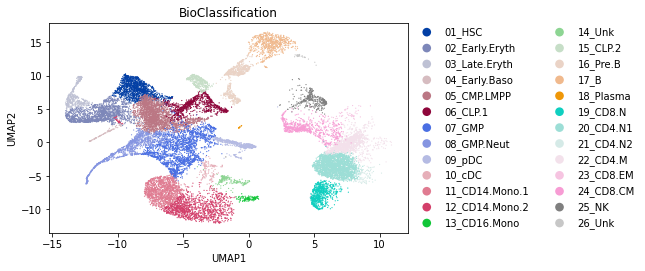

In [3]:
sc.pl.scatter(adata, x='UMAP1', y='UMAP2', color='BioClassification')

To confirm the cell type labels that come with this dataset, I compiled the following table that shows which of the proteins included in this study should be expressed by which cell types. Not all of the cell types they've included can be identified using only these 21 proteins and they probably also used gene expression to identify cell types but a lot of the main categories can be picked out fairly easily.

All leukocytes are positive for CD45. 

CD45RA and RO are splice variants of CD45.

| Cell type | Markers |
|----------|----------|
|HSC | CD34+, CD38-, CD90+ |
|Myeloid Progenitors | CD34+, CD38+, CD33+ |
|Lymphoid Progenitors | CD34+, CD38+, CD10+ |
|Erythroid Progenitors | CD34+, CD38+, CD45RA+ |
|GMP | CD34+, CD38+, CD33+, CD15+ |
|Neutrophils | CD34+, CD38+, CD33+ | 
|Eosinophils | CD34+, CD38+, CD33+, CD123+ |
|Basophils | CD34+, CD38+, CD33+, CD123+ |
|CD14 Monocytes | CD34-, CD14+, CD33+, CD15+, CD45RA+ |
|CD16 Monocytes | CD34-, CD16+, CD33+, CD15+, CD45RA+ |
|Conventional Dendritic Cells | CD45RA+, CD4+ |
|Plasmacytoid Dendritic Cells | CD45RA+, CD4+, CD123+ |
|B Cells | CD45RA+, CD19+ |
|All T Cells | CD3+ |
|CD4 Naive T Cells | CD45RA+, CD4+, CD127+, CD45RO-, CD25- |
|CD4 Central Memory T Cells | CD4+, CD25+, CD45RA-, CD45RO+, CD127+ |
|CD4 Effector Memory T Cells | CD4+, CD25-, CD45RA-, CD45RO+, CD127+ |
|CD8 Naive T Cells | CD8A+, CD45RA+, CD45RO- |
|CD8 Central Memory T Cells | CD8A+, CD45RA-, CD45RO+, TIGIT+ |
|CD8 Effector Memory T Cells | CD8A+, CD45RA-, CD45RO+ |
|NK Cells | CD56+, CD3-, TIGIT+ |

In [4]:
# create df for visualisation
df = pd.concat([adata.obs['BioClassification'], adt], axis = 1)

/home/sarah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




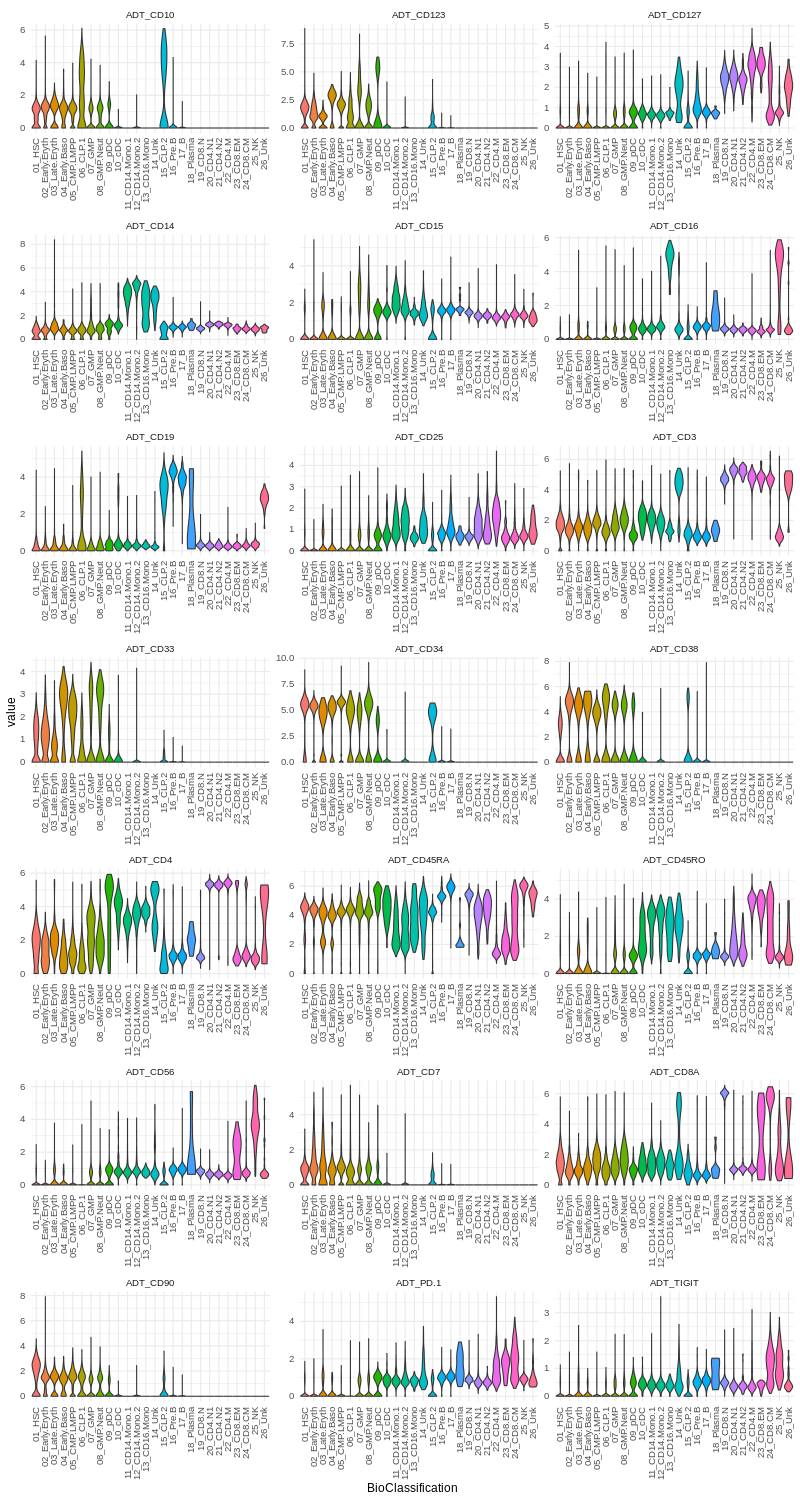

In [5]:
%%R -i df -h 1500 -w 800
library(ggplot2)
library(dplyr)
library(tidyr)

# check which cell types the different proteins are being expressed in
df <- df %>% pivot_longer(2:ncol(df), names_to = 'Protein')
ggplot(df, aes(x = BioClassification, y = value, fill = BioClassification)) +
    geom_violin(scale = 'width', show.legend = F) +
    facet_wrap(~Protein, scales = 'free', nrow = 7) +
    theme_minimal(base_size = 12) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    ggsave('../figures/granja_orig_markers1.png', height=20, width=15)

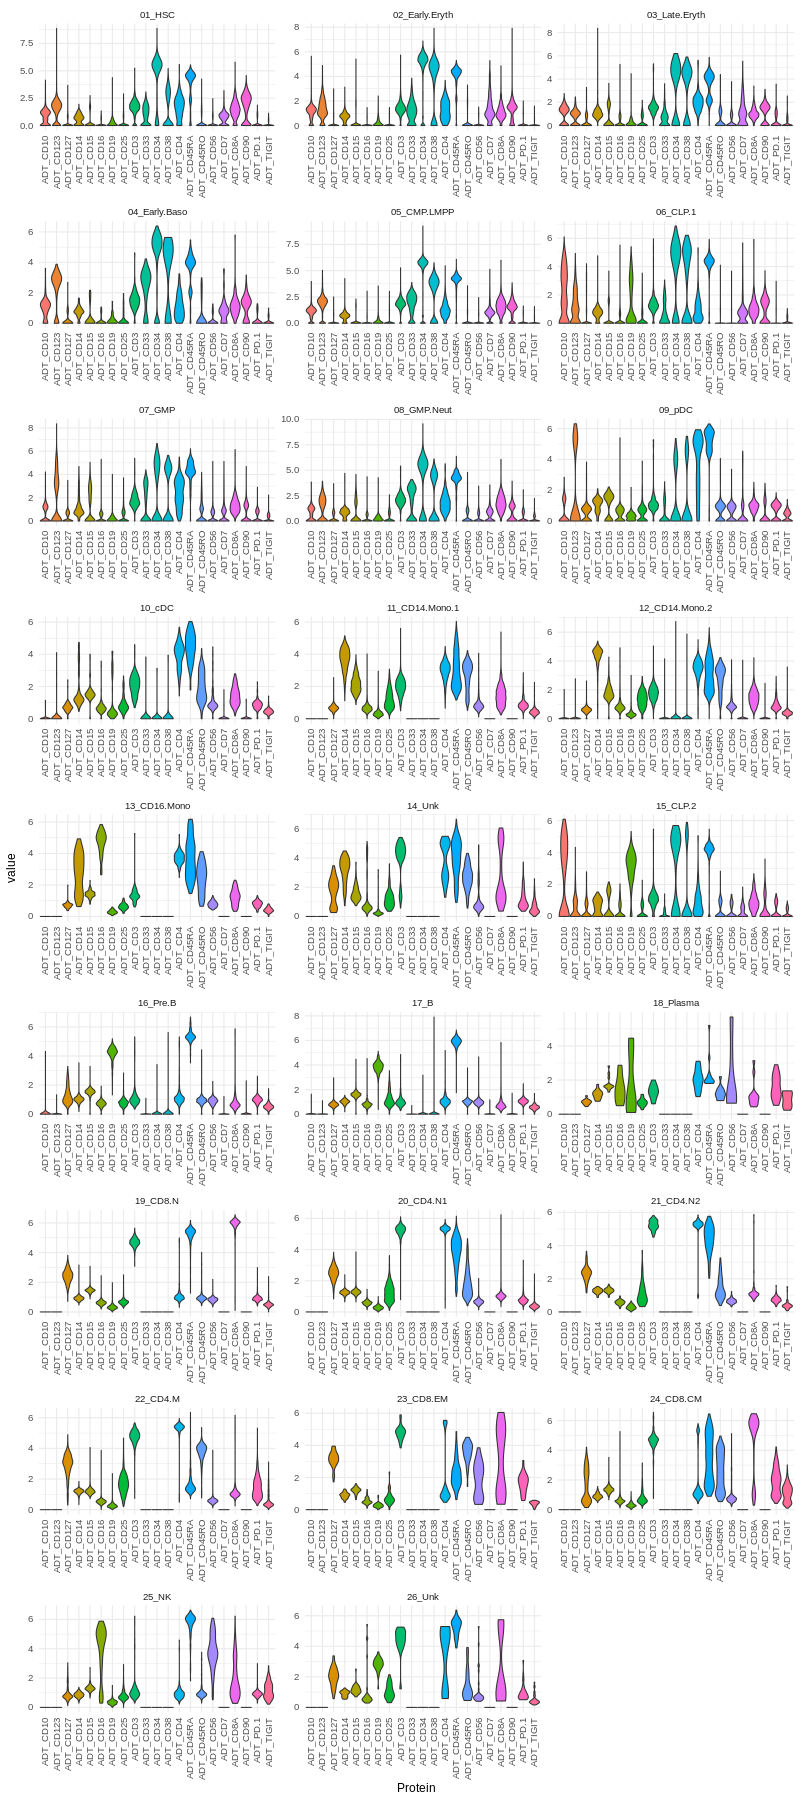

In [6]:
%%R -i df -h 1800 -w 800

# check which proteins are being expressed in each cell type
df <- df %>% pivot_longer(2:ncol(df), names_to = 'Protein')
ggplot(df, aes(x = Protein, y = value, fill = Protein)) +
    geom_violin(scale = 'width', show.legend = F) +
    facet_wrap(~BioClassification, scales = 'free', nrow = 9) +
    theme_minimal(base_size = 12) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    ggsave('../figures/granja_orig_markers2.png', height=20, width=15)

All cell type labels look really good so far. Seeing as I'm going to be using this dataset as my 'Gold Standard' for predicting cell type labels in other datasets, I want to see if I can identify the two categories they have labelled as '14_Unk' and '26_Unk'. I also want to see if it's possible to identify more T cell categories such as Tregs.

normalizing counts per cell
    finished (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_unk']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


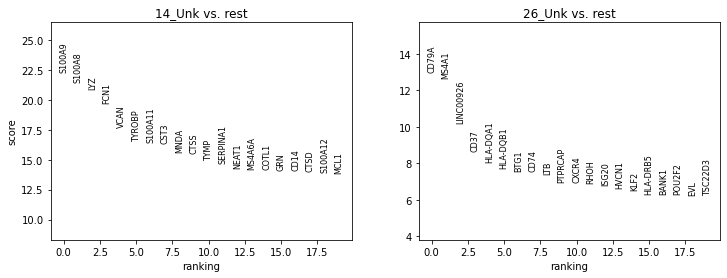

In [7]:
# First need to normalise the data
adata.layers['counts'] = adata.X
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)
adata.raw = adata

# Identify which genes are differentially expressed by the 2 unknown categories to try figure out what they are
sc.tl.rank_genes_groups(adata, groupby='BioClassification', groups=['14_Unk', '26_Unk'], key_added = 'rank_genes_unk')
sc.pl.rank_genes_groups(adata, key='rank_genes_unk', sharey=False)

Looking at the genes they express, 14_Unk cells look like monocytes and 26_Unk cells look like B cells. However, looking at the surface protein expression for these cells, they also both express T cell markers like CD3, CD4 and CD8A. Maybe these are doublets where T cells got caught in droplets with other cells? 

In [8]:
# which samples are these cell types found in?
adata.obs[(adata.obs['BioClassification'] == '14_Unk') | (adata.obs['BioClassification'] == '26_Unk')]['Group'].value_counts()

BMMC_D1T1    129
BMMC_D1T2     91
CD34_D3T1      0
CD34_D2T1      0
Name: Group, dtype: int64

Preprocessing...


/home/sarah/anaconda3/lib/python3.7/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/home/sarah/anaconda3/lib/python3.7/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.38
Detected doublet rate = 2.4%
Estimated detectable doublet fraction = 65.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.6%
Elapsed time: 11.4 seconds


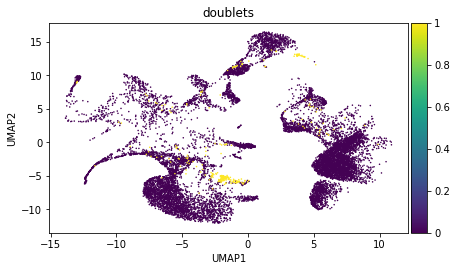

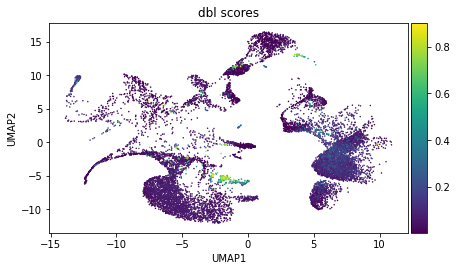

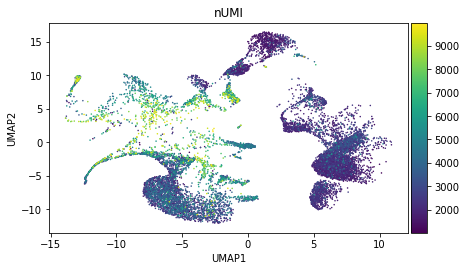

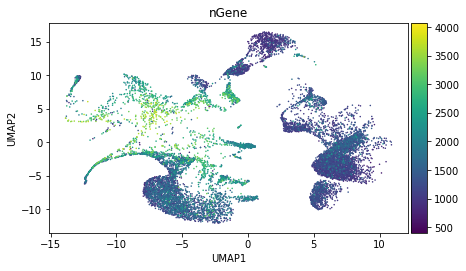

In [9]:
# unknown cell types only found in the BMMC samples, will test for doublets in this sample using scrublet
bm = adata[(adata.obs['Group'] == 'BMMC_D1T1') | (adata.obs['Group'] == 'BMMC_D1T2')].copy()

import scrublet as scr
counts_matrix = sp.sparse.csc_matrix(bm.layers['counts'])
genes = np.array(bm.var_names.values)
scrub = scr.Scrublet(counts_matrix)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
bm.obs['doublets'] = predicted_doublets
bm.obs['dbl_scores'] = doublet_scores
sc.pl.scatter(bm, x='UMAP1', y='UMAP2', color='doublets')
sc.pl.scatter(bm, x='UMAP1', y='UMAP2', color='dbl_scores')
sc.pl.scatter(bm, x='UMAP1', y='UMAP2', color='nUMI')
sc.pl.scatter(bm, x='UMAP1', y='UMAP2', color='nGene')

/home/sarah/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/sarah/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


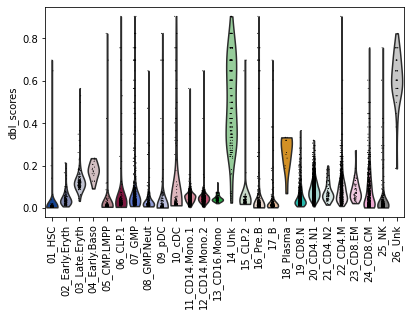

In [10]:
sc.pl.violin(bm, 'dbl_scores', groupby='BioClassification', rotation=90)

In [11]:
# Unknown clusters definitely appear to be clusters of doublets
# will remove them from dataset
adata = adata[(adata.obs['BioClassification'] != '14_Unk') & (adata.obs['BioClassification'] != '26_Unk')].copy()
adata

AnnData object with n_obs × n_vars = 20558 × 20287
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'BioClassification', 'Barcode', 'bc', 'ADT_CD10', 'ADT_CD123', 'ADT_CD14', 'ADT_CD19', 'ADT_CD3', 'ADT_CD33', 'ADT_CD34', 'ADT_CD38', 'ADT_CD4', 'ADT_CD45RA', 'ADT_CD7', 'ADT_CD8A', 'ADT_CD90', 'ADT_CD15', 'ADT_CD16', 'ADT_CD56', 'ADT_CD25', 'ADT_CD45RO', 'ADT_PD.1', 'ADT_TIGIT', 'ADT_CD127'
    uns: 'BioClassification_colors', 'log1p', 'rank_genes_unk'
    layers: 'counts'

Now the mystery of unknown cell types has been solved, will see if I can identify more T cell subsets.

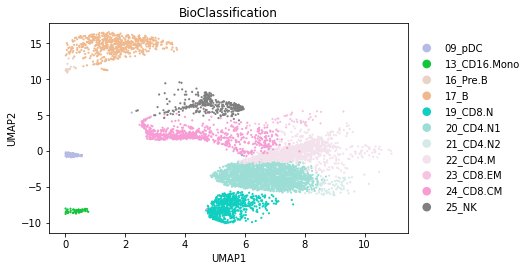

In [12]:
# zoom in on T cells
sc.pl.scatter(adata[adata.obs['UMAP1'] > 0], x='UMAP1', y='UMAP2', color='BioClassification')

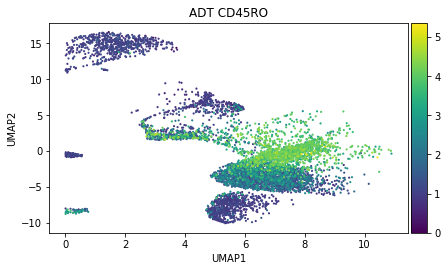

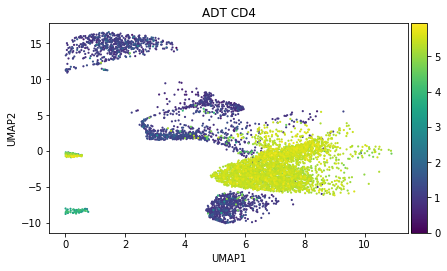

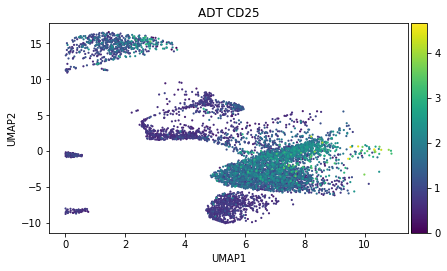

In [13]:
# will see if I can separate CD4 Mem into CD4 central mem and CD4 effector mem
# both should be CD45RO+ and CD4+ but central mem should be CD25+ and effector mem should be CD25-
sc.pl.scatter(adata[adata.obs['UMAP1'] > 0], x='UMAP1', y='UMAP2', color='ADT_CD45RO')
sc.pl.scatter(adata[adata.obs['UMAP1'] > 0], x='UMAP1', y='UMAP2', color='ADT_CD4')
sc.pl.scatter(adata[adata.obs['UMAP1'] > 0], x='UMAP1', y='UMAP2', color='ADT_CD25')

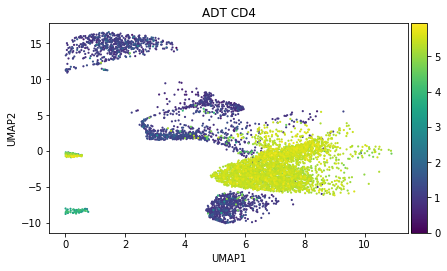

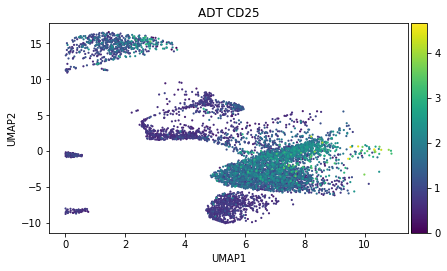

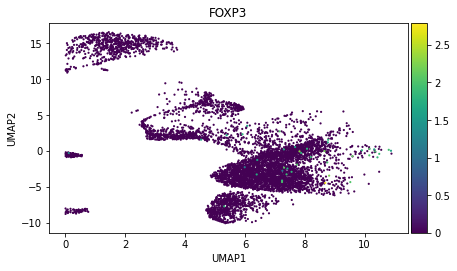

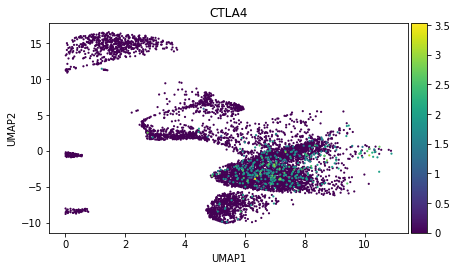

In [23]:
# Not enough cells to try and separate out central and effector CD4 memory cells so will leave them as is
# Will try identify Tregs
# Tregs should be CD4+, CD25+, FOXP3+, CTLA4+
sc.pl.scatter(adata[adata.obs['UMAP1'] > 0], x='UMAP1', y='UMAP2', color='ADT_CD4')
sc.pl.scatter(adata[adata.obs['UMAP1'] > 0], x='UMAP1', y='UMAP2', color='ADT_CD25')
sc.pl.scatter(adata[adata.obs['UMAP1'] > 0], x='UMAP1', y='UMAP2', color='FOXP3')
sc.pl.scatter(adata[adata.obs['UMAP1'] > 0], x='UMAP1', y='UMAP2', color='CTLA4')

There's not enough cells to try and separate out any more subclusters of T cells. I'm pretty happy with the current labels anyway. Will finalise them and save the data so it can be used as my Gold Standard to predict cell types in other datasets.

... storing 'celltype' as categorical


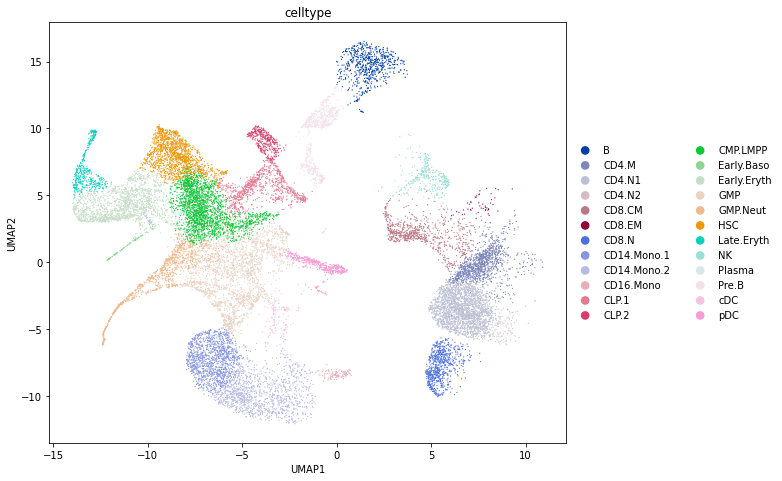

In [33]:
p = re.compile('[^_]+$')
adata.obs['celltype'] = [p.search(x).group() for x in adata.obs['BioClassification'].values]
sc.pl.scatter(adata, x='UMAP1', y='UMAP2', color='celltype')

In [38]:
# confirm marker expression in finalised cell types
df = pd.concat([adata.obs['celltype'], adt], axis = 1)
df = df[~pd.isnull(df['celltype'])]

/home/sarah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


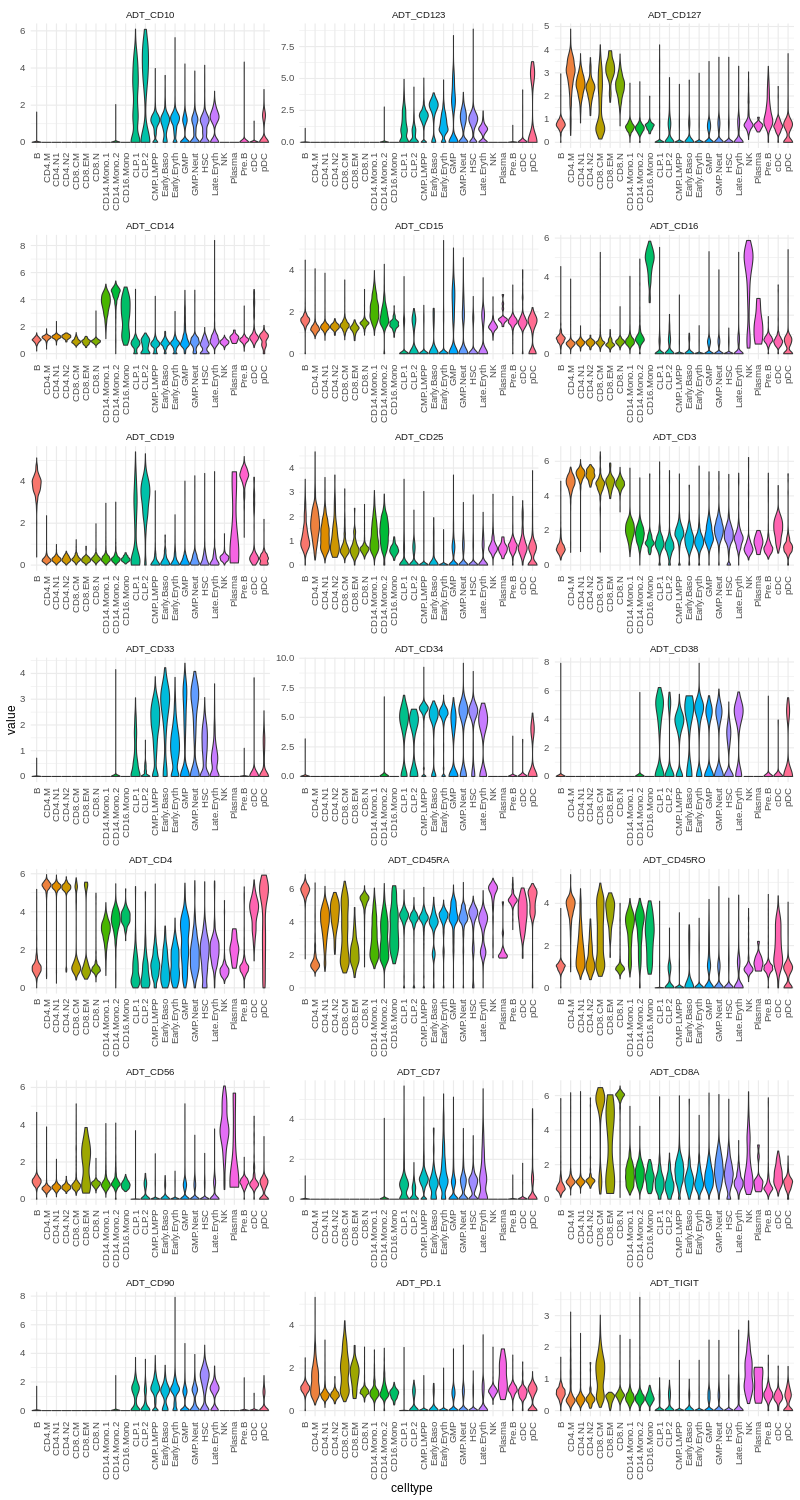

In [39]:
%%R -i df -h 1500 -w 800

# check which cell types the different proteins are being expressed in
df <- df %>% pivot_longer(2:ncol(df), names_to = 'Protein')
ggplot(df, aes(x = celltype, y = value, fill = celltype)) +
    geom_violin(scale = 'width', show.legend = F) +
    facet_wrap(~Protein, scales = 'free', nrow = 7) +
    theme_minimal(base_size = 12) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    ggsave('../figures/granja_final_markers1.png', height=20, width=15)

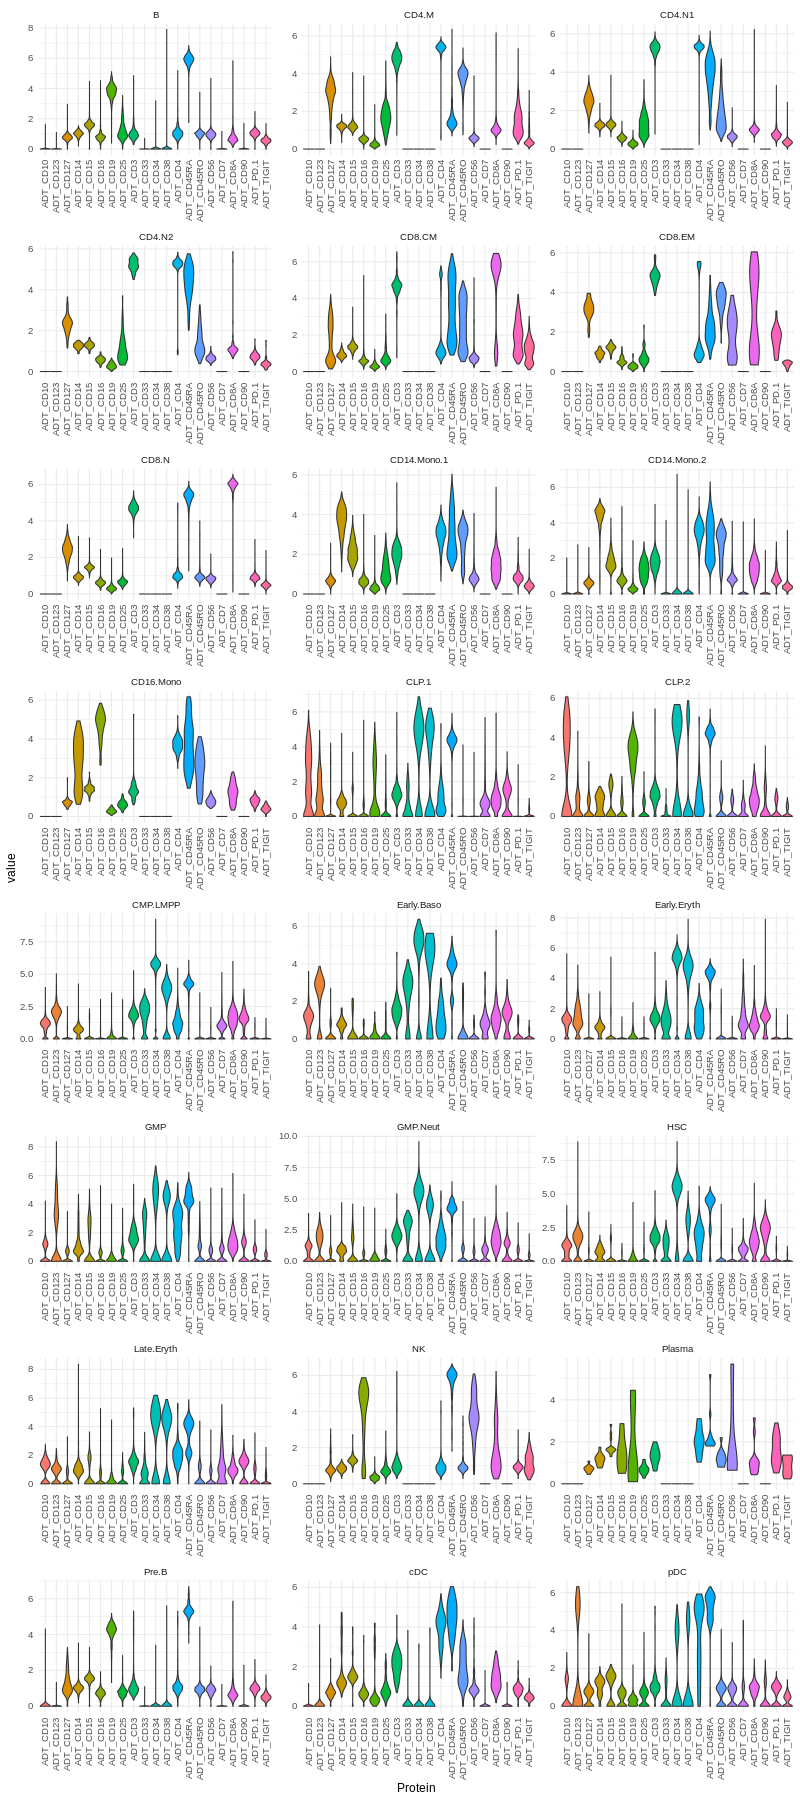

In [40]:
%%R -i df -h 1800 -w 800

# check which proteins are being expressed in each cell type
df <- df %>% pivot_longer(2:ncol(df), names_to = 'Protein')
ggplot(df, aes(x = Protein, y = value, fill = Protein)) +
    geom_violin(scale = 'width', show.legend = F) +
    facet_wrap(~celltype, scales = 'free', nrow = 9) +
    theme_minimal(base_size = 12) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    ggsave('../figures/granja_final_markers2.png', height=20, width=15)

In [42]:
# save data
adata.write('../data/granja/granja.h5ad')